In [1]:
%matplotlib inline

import sys
import numpy as np
import pandas as pd
import scipy as sp
import scanpy as sc
import cassiopeia as cas
import seaborn as sns
import collections
import scipy.sparse as sp_sparse
import scipy.io
import tables
import csv
import statistics as stats

from matplotlib.pyplot import rc_context
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pickle
from pylab import *
from ete3 import Tree
from typing import Tuple

import statistics as stats

In [2]:
clusterColorsFile = "/Genomics/chanlab/mchan/Adriano/TLS/TLS_TLSCL/20211102_clusterColorsTLSCL.p"
with open(clusterColorsFile,'rb') as fp:
    colorDict = pickle.load(fp)

In [3]:
barcodes = ["Bar1", 'Bar2', 'Bar3', 'Bar4', 'Bar5', 'Bar6','Bar7','Bar8','Bar9','Bar10','Bar11', 'Bar12', 'Bar13','Bar14',
            'Bar15', 'Bar16', 'Bar18', 'Bar19','Bar20','Bar21', 'Bar22','Bar23','Bar24']

TLS_barcodes = ['Bar1', 'Bar2', 'Bar4', 'Bar5', 'Bar7', 'Bar10', 'Bar11', 'Bar13', 'Bar16', 'Bar19', 'Bar22']
TLSCL_barcodes = ['Bar3', 'Bar6', 'Bar9', 'Bar12', 'Bar14', 'Bar15', 'Bar20', 'Bar21', 'Bar23', 'Bar24']

In [4]:
# Label internal nodes
def nameInteriorNodes(nwkFile,outnwkFile):

    t = Tree(nwkFile,format=1)
    labelID = 0

    for node in t.traverse():
        if node.is_leaf() == False:
            node.name = "node{}".format(labelID)
            labelID = labelID + 1

    t.write(format=8,outfile=outnwkFile)

In [5]:
def add_node0(nwkFile, outnwkFile):
    infile = open(nwkFile, 'r')
    outfile = open(outnwkFile, 'w')
    
    outfile.write(infile.readline()[:-1])
    outfile.write('node0;')
          
    infile.close()
    outfile.close()

In [6]:
def nodeClusterProfile(node, data, colName, df):
    if node.is_leaf():
        clusterID = data.loc[node.name,colName]
        df.loc[node.name,clusterID] = 1
        return 1
    else:
        daughters = node.children
        nodeNames = []
        for d in daughters:
            nodeClusterProfile(d,data,colName,df)
            nodeNames.append(d.name)
        df.loc[node.name,:] = df.loc[nodeNames,:].sum()
        return 1

In [7]:
def makeNodeMetaTable(nwkFile, metaFile, colName, outMetaFile):

    t = Tree(nwkFile,format=1)
    
    # get node names from tree;
    nodeNameList = []
    for node in t.traverse():
        nodeNameList.append(node.name)

    data = pd.read_csv(metaFile, sep='\t')
    data.set_index("cellBC", inplace=True)

    # best to initialize data frame with rows and columns when possible
    # (try not to grow dataframes)
    #clusterNames = data[colName].unique()
    clusterNames = ["['Somite']", "['Somite-1']", "['SomiteSclero']", "['NeuralTube1']", "['Somite0']", "['NeuralTube2']", 
                    "['NMPs']", "['SomiteDermo']", "['Unknown']", "['Endothelial']", "['pPSM']", "['aPSM']", "['PCGLC']",
                    "['Endoderm']"]

    df_meta = pd.DataFrame(columns = clusterNames, index = nodeNameList)
    df_meta.fillna(0, inplace = True)
    df_meta.index.name = "cellBC"

    nodeClusterProfile(t.get_tree_root(), data, colName, df_meta)
    df_meta.to_csv(outMetaFile, sep="\t")

In [8]:
def maxDepth(node):
    '''
    Input:
        - a node in an ete tree
    returns:
        - The max depth of any branch in that node
    '''
    if node.is_leaf():
        return 0
    children_depths = []
    
    for child in node.children:
        test = maxDepth(child)
        
        children_depths.append(test)
        
    return max(children_depths) + 1

In [18]:
# Labels the nodes
for barcode in barcodes:
    if barcode != 'Bar3':
        nameInteriorNodes('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/lineage/3_lineage_reconstruction/{}/{}_ilp_newick_noMutationlessEdges.txt'.format(barcode, barcode),
                          '/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/lineage/3_lineage_reconstruction/{}/{}_node0_missing.txt'.format(barcode, barcode))
    else:
        nameInteriorNodes('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/lineage/3_lineage_reconstruction/{}/{}_hybrid_newick_noMutationlessEdges.txt'.format(barcode, barcode),
                          '/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/lineage/3_lineage_reconstruction/{}/{}_node0_missing.txt'.format(barcode, barcode))

In [19]:
# Add the node0 label
for barcode in barcodes:
    add_node0('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/lineage/3_lineage_reconstruction/{}/{}_node0_missing.txt'.format(barcode, barcode),
              '/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/lineage/3_lineage_reconstruction/{}/{}_newick_noMutationlessEdges_Labeled.nwk'.format(barcode, barcode))

In [21]:
# Make a cluster metadata table
for barcode in barcodes:
    test = makeNodeMetaTable('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/lineage/3_lineage_reconstruction/{}/{}_newick_noMutationlessEdges_Labeled.nwk'.format(barcode, barcode),
                      '/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/lineage/3_lineage_reconstruction/{}/{}_metadata.txt'.format(barcode, barcode),
                      'cell_state',
                      '/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/lineage/3_lineage_reconstruction/{}/{}_clusterTable.txt'.format(barcode, barcode))

### Record important stats for each structure

In [9]:
stats = ['n_of_cells', 'n_of_nodes', 'n_of_clones', 'median_clone_size', 'mean_clone_size', 'max_clone_size', 'mean_clone_depth', 
         'max_clone_depth', 'n_unique_indels', 'n_unique_alleles', 'n_unique_lineage_BC']

structure_stats = pd.DataFrame(index = barcodes, columns = stats)

In [16]:
for barcode in barcodes:
    treeFile = "/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/lineage/3_lineage_reconstruction/{}/{}_newick_noMutationlessEdges_Labeled.nwk".format(barcode, barcode)
    t = Tree(treeFile, format = 1)
    lineage_table = pd.read_csv("/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/lineage/3_lineage_reconstruction/{}/{}_lineage_table.txt".format(barcode, barcode), sep = '\t')
    allele_table = pd.read_csv("/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/lineage/3_lineage_reconstruction/allele_table_filtered.txt", sep='\t')

    # Load the cassiopeia Tree
    tree_meta = pd.read_csv("/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/lineage/3_lineage_reconstruction/{}/{}_metadata.txt".format(barcode, barcode), sep='\t')
    character_matrix = pd.read_csv("/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/lineage/3_lineage_reconstruction/{}/{}_character_matrix.txt".format(barcode, barcode), sep='\t', index_col = 0)

    prior_file = "/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/lineage/3_lineage_reconstruction/{}/{}_priors.pickle".format(barcode, barcode)
    with open(prior_file, 'rb') as f:
        priors = pickle.load(f)

    test_tree = cas.data.CassiopeiaTree(character_matrix=character_matrix, priors=priors, tree = t)

    missing_proportion = (character_matrix == -1).sum(axis=0) / character_matrix.shape[0]
    uncut_proportion = (character_matrix == 0).sum(axis=0) / character_matrix.shape[0]
    n_unique_states = character_matrix.apply(lambda x: len(np.unique(x[(x != 0) & (x != -1)])), axis=0)

    character_meta = pd.DataFrame([missing_proportion, uncut_proportion, n_unique_states], index = ['missing_prop', 'uncut_prop', 'n_unique_states']).T
    test_tree.cell_meta = tree_meta
    test_tree.character_meta = character_meta
    test_tree.parameters['stochastic_missing_probability'] = 0.1
    
    n_of_cells = test_tree.n_cell
    
    n_of_nodes = 0
    for node in t.traverse():
        if not node.is_leaf() and node.name != 'node0':
            n_of_nodes += 1
            
    n_of_clones = len(t.children)
    
    # Calculate the depth and size for each clone in the tree (children of the root node)
    clone_sizes = []
    clone_max_depths = []

    for clone in t.children:
        clone_sizes.append(len(clone))
        clone_max_depths.append(maxDepth(clone))

    median_clone_size = np.median(clone_sizes)
    mean_clone_size = np.mean(clone_sizes)
    max_clone_size = max(clone_sizes)
    mean_clone_depth = np.mean(clone_max_depths)
    max_clone_depth = max(clone_max_depths)
    
    # Calculate the number of unique alleles and unique indels
    cellBC = [leaf.name for leaf in t.get_leaves()]
    temp_allele_table = allele_table[allele_table['cellBC'].isin(cellBC)]

    unique_indels = set()
    for indel in temp_allele_table['r1']:
        unique_indels.add(indel)
    for indel in temp_allele_table['r2']:
        unique_indels.add(indel)
    for indel in temp_allele_table['r3']:
        unique_indels.add(indel)

    n_of_unique_alleles = len(np.unique(temp_allele_table['allele']))
    n_of_unique_indels = len(unique_indels)
    
    indel_sites = lineage_table.columns[1:]
    lineage_table.fillna('[Null]', inplace = True)
    lineage_table['lineageBC'] = lineage_table[indel_sites].apply("".join, axis=1)
    
    # Calculate the number of unique lineage barcodes
    unique_lineage_BC = set()

    for row in lineage_table.iterrows():
        unique_lineage_BC.add(row[1]['lineageBC'])

    n_of_unique_lineage_BC = len(unique_lineage_BC)
    
    # Save all metrics to the table
    structure_stats.loc[barcode]['n_of_cells'] = n_of_cells
    structure_stats.loc[barcode]['n_of_nodes'] = n_of_nodes
    structure_stats.loc[barcode]['n_of_clones'] = n_of_clones
    structure_stats.loc[barcode]['median_clone_size'] = median_clone_size
    structure_stats.loc[barcode]['mean_clone_size'] = mean_clone_size
    structure_stats.loc[barcode]['max_clone_size'] = max_clone_size
    structure_stats.loc[barcode]['mean_clone_depth'] = mean_clone_depth
    structure_stats.loc[barcode]['max_clone_depth'] = max_clone_depth
    structure_stats.loc[barcode]['n_unique_indels'] = n_of_unique_indels
    structure_stats.loc[barcode]['n_unique_alleles'] = n_of_unique_alleles
    structure_stats.loc[barcode]['n_unique_lineage_BC'] = n_of_unique_lineage_BC

In [17]:
structure_stats.to_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/lineage/lineage_stats/structure_stats.txt', sep = '\t')

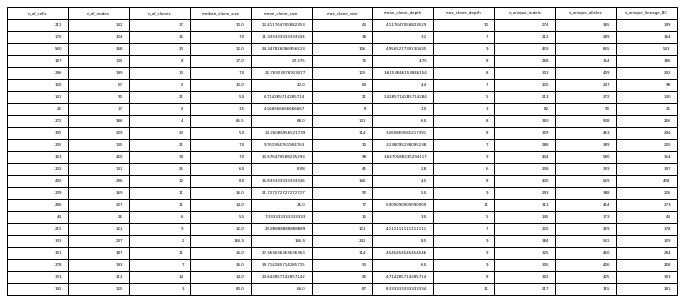

In [18]:
temp = structure_stats.copy()
temp['Barcode'] = temp.index.values

#https://stackoverflow.com/questions/32137396/how-do-i-plot-only-a-table-in-matplotlib
fig, ax =plt.subplots(figsize=(12,4))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=structure_stats.values,colLabels=structure_stats.columns,loc='center')

#https://stackoverflow.com/questions/4042192/reduce-left-and-right-margins-in-matplotlib-plot
pp = PdfPages("AM-DNA-258_Lineage_Stats.pdf")
pp.savefig(fig, bbox_inches='tight')
pp.close()

### Plot the cell states for each barcode (split by TLSCL and TLS)

In [19]:
df_cell_compositions = pd.DataFrame(index = barcodes, columns = colorDict.keys())

In [20]:
for barcode in barcodes:
    clusterFile = "/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/lineage/3_lineage_reconstruction/{}/{}_clusterTable.txt".format(barcode, barcode)
    clusterTable = pd.read_csv(clusterFile, index_col = 0, sep = '\t')
    
    for cellType in colorDict.keys():
        df_cell_compositions.loc[barcode][cellType] = clusterTable.loc['node0']["['" + cellType + "']"]

In [21]:
df_cell_compositions['Total'] = df_cell_compositions.sum(axis = 1)

In [22]:
df_cell_compositionsF = df_cell_compositions.div(df_cell_compositions["Total"], axis = 0)


In [23]:
df_cell_compositionsF

,pPSM,Somite,aPSM,NeuralTube1,NeuralTube2,Somite-1,Unknown,PCGLC,Somite0,NMPs,Endoderm,SomiteSclero,Endothelial,SomiteDermo,Total
Bar1,0.004739,0.047393,0.009479,0.303318,0.218009,0.080569,0.004739,0.004739,0.047393,0.066351,0.0,0.180095,0.004739,0.028436,1.0
Bar2,0.070588,0.017647,0.017647,0.123529,0.270588,0.011765,0.005882,0.0,0.052941,0.247059,0.0,0.1,0.005882,0.076471,1.0
Bar3,0.119643,0.051786,0.021429,0.114286,0.0,0.0,0.001786,0.0,0.046429,0.558929,0.0,0.032143,0.0,0.053571,1.0
Bar4,0.058824,0.016043,0.080214,0.112299,0.208556,0.069519,0.005348,0.0,0.032086,0.176471,0.0,0.144385,0.016043,0.080214,1.0
Bar5,0.040541,0.037162,0.030405,0.192568,0.206081,0.016892,0.003378,0.003378,0.02027,0.253378,0.016892,0.121622,0.003378,0.054054,1.0
Bar6,0.18,0.24,0.03,0.07,0.0,0.0,0.0,0.0,0.05,0.16,0.01,0.02,0.0,0.24,1.0
Bar7,0.014184,0.028369,0.007092,0.241135,0.248227,0.042553,0.021277,0.007092,0.021277,0.198582,0.0,0.120567,0.0,0.049645,1.0
Bar8,0.04,0.0,0.04,0.16,0.2,0.04,0.0,0.0,0.0,0.28,0.0,0.12,0.0,0.12,1.0
Bar9,0.084559,0.213235,0.033088,0.102941,0.003676,0.007353,0.0,0.003676,0.084559,0.227941,0.0,0.080882,0.0,0.158088,1.0
Bar10,0.02623,0.022951,0.036066,0.137705,0.186885,0.062295,0.009836,0.0,0.039344,0.167213,0.013115,0.186885,0.009836,0.101639,1.0


In [24]:
colors = []
for color in df_cell_compositionsF.drop(columns = 'Total').columns:
    colors.append(colorDict[color])

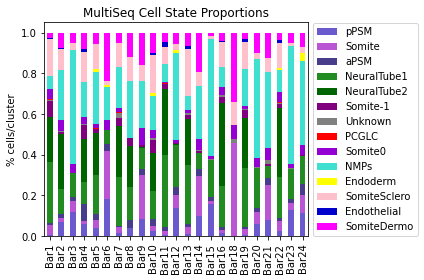

In [25]:
df_cell_compositionsF.drop(columns = 'Total').plot(kind='bar', use_index = True, stacked=True, color = colors, grid = False)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('MultiSeq Cell State Proportions')
plt.ylabel('% cells/cluster')
plt.tight_layout()
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/lineage/lineage_stats/MultiSeq_Cell_Composition.pdf', dpi = 300)
plt.show()
plt.close()

In [26]:
TLSList = ["Bar4","Bar16","Bar10","Bar7", "Bar1","Bar13","Bar5","Bar11", "Bar2","Bar19","Bar8","Bar22"]

TLSCLList = ["Bar3", "Bar6","Bar12","Bar21","Bar24", "Bar14","Bar23","Bar15","Bar9", "Bar20"]

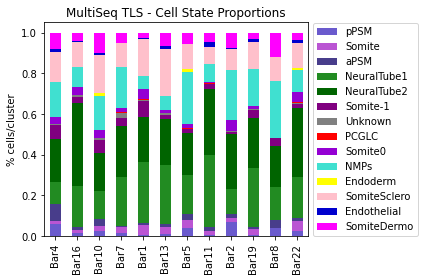

In [27]:
df_cell_compositionsF.loc[TLSList].drop(columns = 'Total').plot(kind='bar', use_index = True, stacked=True, color = colors, grid = False)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('MultiSeq TLS - Cell State Proportions')
plt.ylabel('% cells/cluster')
plt.tight_layout()
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/lineage/lineage_stats/MultiSeq_TLS_Cell_Composition.pdf', dpi = 300)
plt.show()
plt.close()

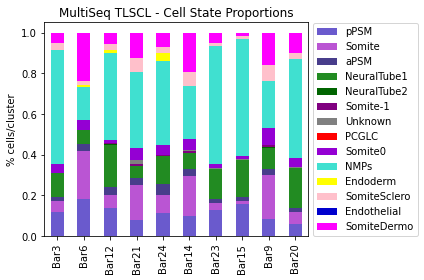

In [28]:
df_cell_compositionsF.loc[TLSCLList].drop(columns = 'Total').plot(kind='bar', use_index = True, stacked=True, color = colors, grid = False)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('MultiSeq TLSCL - Cell State Proportions')
plt.ylabel('% cells/cluster')
plt.tight_layout()
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/lineage/lineage_stats/MultiSeq_TLSCL_Cell_Composition.pdf', dpi = 300)
plt.show()
plt.close()

In [31]:
for barcode in barcodes:
    clusterFile = "/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/lineage/3_lineage_reconstruction/{}/{}_clusterTable.txt".format(barcode, barcode)
    clusterTable = pd.read_csv(clusterFile, index_col = 0, sep = '\t')
    columns =  [i[2:-2] for i in clusterTable.columns]
    clusterTable.columns = columns
    clusterTable['Total'] = clusterTable.sum(axis = 1)
    
    t = '/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/lineage/3_lineage_reconstruction/{}/{}_newick_noMutationlessEdges_Labeled.nwk'.format(barcode, barcode)
    tree = Tree(t, format=1)
    
    clones = []
    for clone in tree.children:
        clones.append(clone.name)
        
    cloneTable = clusterTable.loc[clones]
    cloneTable.sort_values('Total', ascending = False, inplace = True)

    colors = []
    for color in clusterTable.drop(columns = 'Total').columns:
        colors.append(colorDict[color])
        
    cloneTable.drop(columns = 'Total').plot(kind='bar', use_index = True, stacked=True, color = colors, grid = False, figsize = (5, 5))
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title('{} - Cell State Proportions per node'.format(barcode))
    plt.ylabel('cells per node')
    plt.tight_layout()
    plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-258/composition/structure_clones/{}_Node_Cell_Composition.pdf'.format(barcode), dpi = 300)
    #plt.show()
    plt.close()